In [1]:
import numpy as np
import torch
from pathlib import Path
import os
from bnn_priors.models import RaoBDenseNet
import matplotlib.pyplot as plt

from pyro.infer.mcmc import NUTS, HMC
from pyro.infer.mcmc.api import MCMC

In [2]:
data = np.load("../bnn_priors/data/snelson.npz")

device = ('cuda' if torch.cuda.is_available() else 'cpu')
x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(device=device, dtype=torch.get_default_dtype())
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

model = RaoBDenseNet(x_train, y_train, 100, noise_std=0.1).to(x_train)

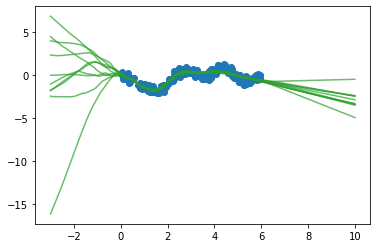

In [3]:
for _ in range(10):
    model.sample_all_priors()
    with torch.no_grad():
        plt.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()

In [6]:
N_steps = 200
warmup = 1000

kernel = HMC(potential_fn=model.get_potential(x_train, y_train),
             adapt_step_size=False, adapt_mass_matrix=False,
             step_size=1/1024, num_steps=32)
mcmc = MCMC(kernel, num_samples=N_steps, warmup_steps=warmup, initial_params = model.params_with_prior_dict())
mcmc.run()

samples = mcmc.get_samples()

Sample: 100%|██████████| 1200/1200 [02:10,  9.20it/s, step size=9.77e-04, acc. prob=0.729]


The following plot looks thinner than the one in `1.0_HMC_test`. This can be explained by remembering that we are displaying the **mean** of the latent function, conditional on the weights up until the previous to last layer; as opposed to **samples** from the latent function.

(-4, 4)

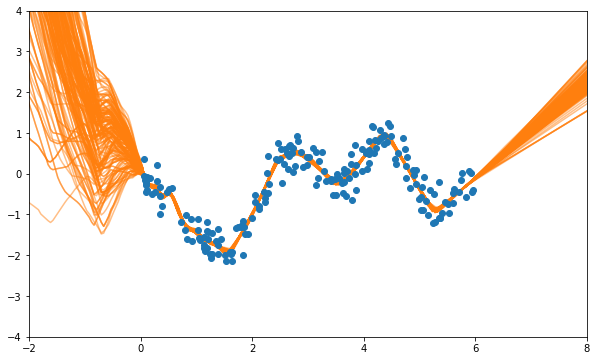

In [7]:
_, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(N_steps):
    sample = dict((k, v[i]) for k, v in samples.items())
    with torch.no_grad(), model.using_params(sample):
        ax.plot(x_test.cpu(), model(x_test).loc.cpu(), color="C1", alpha=0.5)
ax.plot(x_train.cpu(), y_train.cpu(), "o")
ax.set_xlim(-2, 8)
ax.set_ylim(-4, 4)